<a href="https://colab.research.google.com/github/ksi81/HW_7_Classification-and-assessment-of-model-performance/blob/main/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [6]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

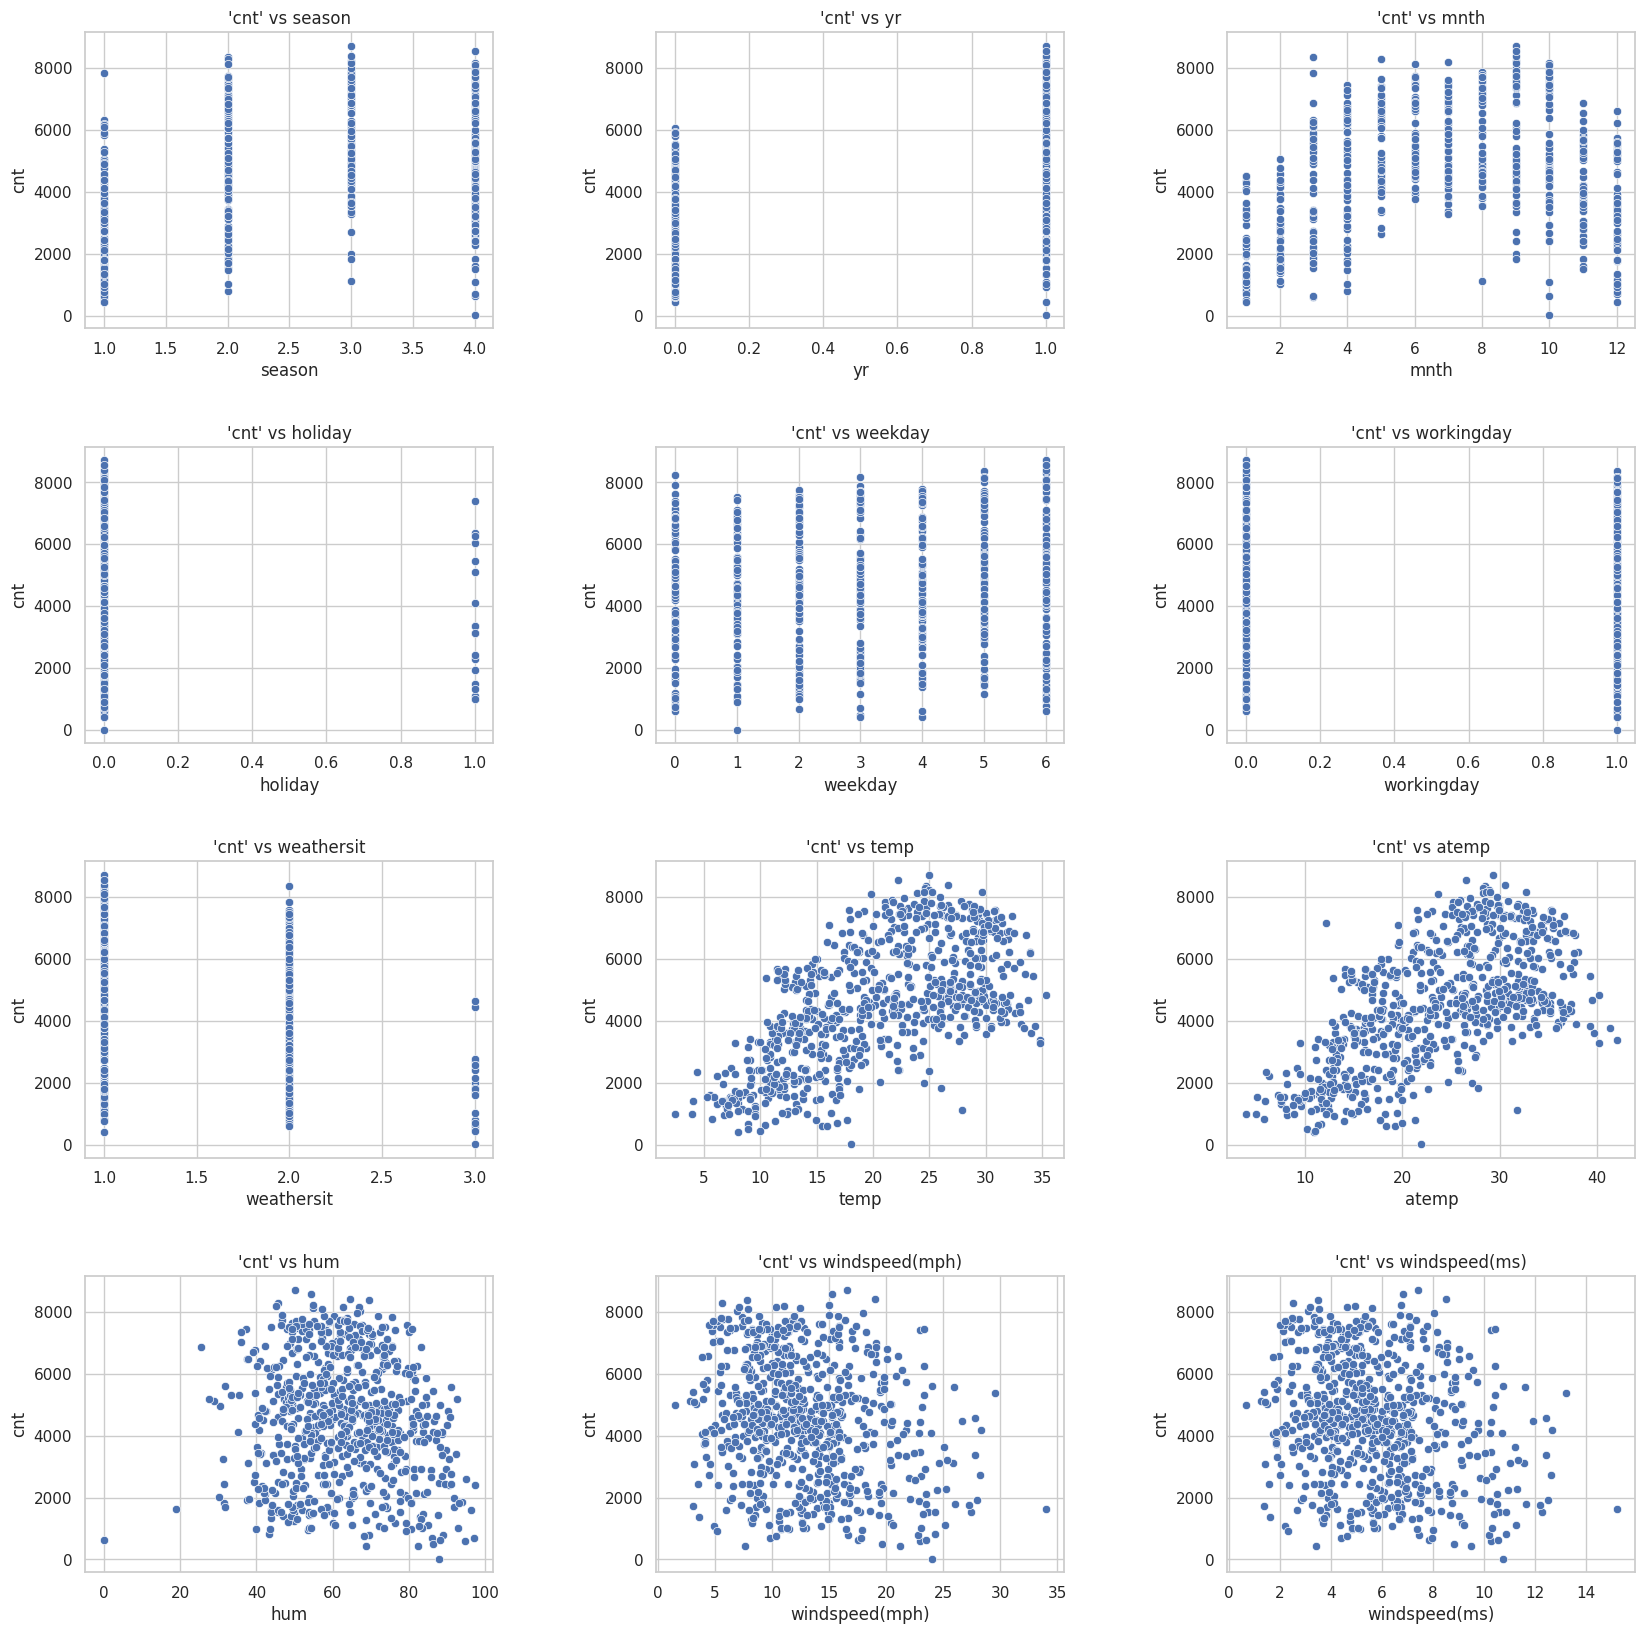

In [7]:
# Put you code here
import seaborn as sns

sns.set(style="whitegrid")

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Список усіх функцій, крім "cnt"
features = df.columns[:-1]

# зв'язок кожної функції з 'cnt'
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.scatterplot(data=df, x=feature, y='cnt', ax=axs[row, col]).set(title=f"'cnt' vs {feature}")

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?

Залежність кількості прокатів від місяця виглядає не лінійною, але має деяку сезонність. З графіка видно, що кількість прокатів зростає з весни до осені , після чого знову знижується в кінці осені. Це свідчить про те, що більш сприятливі погодні умови (тепліше) спонукають людей частіше користуватися велосипедами для прокату. Отже, характер залежності містить явну сезонну компоненту, де теплі  місяці є найбільш популярними для прокату велосипедів.

1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Температура (temp) - на графіку видно, що існує певна тенденція до збільшення кількості прокатів із зростанням температури, що вказує на потенційну лінійну залежність. Користувачі віддають перевагу велосипедним поїздкам при комфортнішій погоді.
Рік (yr) - хоча у нас всього два роки даних (2011 та 2012), на графіку помітно зростання кількості прокатів з одного року до наступного, що може свідчити про збільшення популярності сервісу прокату велосипедів з часом. Це може вказувати на лінійну залежність кількості прокатів від року, з урахуванням збільшення інтересу до велосипедного транспорту або розширення самого сервісу.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [9]:
# Put your code here
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

Кореляція Пірсона варіюється від -1 до 1. Величина ближче до 1 або -1 вказує на сильну лінійну залежність, тоді як величина ближче до 0 вказує на відсутність лінійної залежності.

З результатів видно, що найбільш виражену позитивну лінійну залежність з кількістю орендованих велосипедів мають такі ознаки:

temp (температура в Цельсіях) та atemp (температура за відчуттями в Цельсіях) з кореляцією близько 0.63

yr (рік) з кореляцією 0.57, що вказує на зростання популярності сервісу прокату велосипедів з часом.

Ознака weathersit (оцінка погоди) має найбільш виражену негативну кореляцію (-0.30), що вказує на те, що менш сприятливі погодні умови ведуть до зменшення кількості орендованих велосипедів.

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

In [10]:
numerical_features_correlation = df.select_dtypes(include=['float64', 'int64']).corr()
numerical_features_correlation

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


Кореляційна матриця між речовими ознаками вказує на наступні важливі взаємозв'язки:

Температура (temp) та відчуття температури (atemp) мають дуже високу кореляцію між собою (приблизно 0.99), що свідчить про дуже сильний лінійний зв'язок. Це логічно, адже atemp являє собою оцінку температури за відчуттями, яка базується на фактичній температурі temp.
Сезон (season) та місяць (mnth) також мають високу кореляцію (0.83), що є зрозумілим, оскільки сезони змінюються в залежності від місяця.
Вологість (hum) та оцінка погоди (weathersit) мають помірну позитивну кореляцію (приблизно 0.59), вказуючи на те, що вища вологість може бути асоційована з менш сприятливими погодними умовами.
Швидкість вітру в милях за годину (windspeed(mph)) та швидкість вітру в метрах за секунду (windspeed(ms)) мають ідеальну кореляцію (1.0), оскільки це просто дві міри однієї та тієї ж характеристики, виражені в різних одиницях.
Ці взаємозв'язки слід враховувати при моделюванні, оскільки висока кореляція між ознаками може призвести до проблеми мультиколінеарності в лінійних моделях. Наприклад, оскільки temp та atemp майже ідентично корелюють з цільовою змінною і між собою, можливо, варто використовувати лише одну з цих ознак для моделювання.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [11]:
# Put your code here
specified_features_correlation = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
specified_features_correlation

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt вказують на наступне:

temp і atemp мають дуже високу кореляцію між собою (0.99), що вказує на майже ідентичну інформацію, яку вони носять про температуру. Це очікувано, оскільки обидві ознаки описують температуру, але в різних вимірах (фактична та відчутна температури).
temp і atemp мають виражену позитивну кореляцію з кількістю орендованих велосипедів (cnt), що свідчить про збільшення кількості прокатів із підвищенням температури.
hum (вологість) має невелику негативну кореляцію з cnt (-0.10), що може свідчити про те, що з дуже високою вологістю трохи знижується кількість прокатів.
windspeed(mph) і windspeed(ms) мають ідентичну негативну кореляцію з cnt (-0.23), що вказує на зменшення кількості прокатів при збільшенні швидкості вітру. Оскільки ці дві ознаки є просто різними одиницями виміру однієї й тієї ж характеристики, їхня кореляція з іншими ознаками ідентична.
Ці результати підтверджують, що temp та atemp є важливими предикторами для кількості орендованих велосипедів і можуть бути корисними для моделювання. Також, враховуючи високу кореляцію між temp та atemp, можливо, варто використовувати лише одну з цих ознак у моделі, щоб уникнути мультиколінеарності.

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [12]:
# Put your code here
mean_values = df.mean()
mean_values

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Середні значення ознак у датасеті надають інформацію про масштаб та розподіл ознак:

season: Середнє значення приблизно 2.5 вказує, що дані рівномірно розподілені по сезонах року.
yr: Середнє значення 0.5 свідчить про рівний розподіл між двома роками (2011 і 2012).

mnth: Середнє близько 6.52, що вказує на рівномірне представлення місяців у датасеті.

holiday: Середнє значення 0.0287 показує, що більшість днів у датасеті не є святковими.

weekday: Середнє значення близько 3, що свідчить про рівномірне представлення днів тижня.

workingday: Середнє 0.684 показує, що більшість днів є робочими.
weathersit: Середнє значення 1.395 вказує на переважання днів з хорошими погодними умовами.

temp (температура в Цельсіях): Середнє значення 20.31°C.

atemp (відчутна температура): Середнє значення 23.72°C.

hum (вологість): Середнє значення 62.79%.

windspeed(mph) (швидкість вітру в милях за годину): Середнє 12.76 mph.

windspeed(ms) (швидкість вітру в метрах за секунду): Середнє 5.705 м/с.

cnt (кількість орендованих велосипедів): Середнє значення 4504.35, що демонструє загальний рівень попиту на прокат велосипедів у датасеті.

Ці середні значення допомагають нам зрозуміти масштаб та розподіл даних по різним ознакам, а також частку 1 у бінарних ознаках.

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [13]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [14]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])# scaled_features
y = df_shuffled["cnt"] #target_shuffled

pd.DataFrame(X, columns=df.columns[:-1]).head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1.354375,0.998633,1.588660,-0.171981,-0.497782,0.679706,-0.726048,-0.106884,-0.032545,0.743727,-0.211211,-0.211211
1,-1.348213,-1.001369,-1.310268,-0.171981,0.500513,0.679706,-0.726048,-1.686082,-1.820550,-1.335389,1.126812,1.126812
2,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491
3,-0.447350,0.998633,-0.730482,-0.171981,-1.496077,-1.471225,1.110427,-0.380219,-0.350427,0.339741,-0.235254,-0.235254
4,1.354375,0.998633,0.718982,-0.171981,-0.497782,0.679706,-0.726048,0.298565,0.428770,-0.406755,0.591838,0.591838


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [15]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [16]:
# Put your code here
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
feature_names = df.columns[:-1]
model_weights = linear_regressor.coef_
weights = list(zip(feature_names, model_weights))

weights

[('season', 570.8637960129914),
 ('yr', 1021.9653779400622),
 ('mnth', -141.3017451148728),
 ('holiday', -86.7593446245368),
 ('weekday', 137.22506441350538),
 ('workingday', 56.391881775973005),
 ('weathersit', -330.2264620440312),
 ('temp', 367.48373260182126),
 ('atemp', 585.5493861188597),
 ('hum', -145.61430569885857),
 ('windspeed(mph)', 12457138390688.885),
 ('windspeed(ms)', -12457138390887.346)]

Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [17]:
# Put your code here
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
lasso_weights = lasso_regressor.coef_
lasso_weights_list = list(zip(df.columns[:-1], lasso_weights))

# Lasso model
lasso_weights_list

[('season', 560.2416160308861),
 ('yr', 1019.4634940657196),
 ('mnth', -128.73062703678696),
 ('holiday', -86.15278133371106),
 ('weekday', 137.34789390496314),
 ('workingday', 55.21237064135668),
 ('weathersit', -332.3698569623487),
 ('temp', 376.3632362096943),
 ('atemp', 576.530793504555),
 ('hum', -144.12915500348583),
 ('windspeed(mph)', -197.1396894024843),
 ('windspeed(ms)', -2.8051404183533485e-08)]

Застосування L1-регуляризації зменшило величину ваг при ознаках, зокрема вирішило проблему з аномально великими вагами для windspeed(mph) та windspeed(ms), які були помічені у моделі без регуляризації. Особливо цікаво, що вага для windspeed(ms) стала надзвичайно малою, що свідчить про ефективне усунення моделлю надлишковості цієї ознаки через регуляризацію.

Таким чином, L1-регуляризація допомогла зменшити вплив колінеарності ознак на модель, роблячи її більш стабільною та здатною до узагальнення.

In [ ]:
"""season: 560.241616031
yr: 1019.46349407*
mnth: -128.730627037
holiday: -86.1527813337
weekday: 137.347893905
workingday: 55.2123706414
weathersit: -332.369856962
temp: 376.36323621
atemp: 576.530793505
hum: -144.129155003
windspeed(mph): -197.139689402
windspeed(ms): -2.80498119457e-08"""

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [18]:
# Put your code here
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
ridge_weights = ridge_regressor.coef_
ridge_weights_list = list(zip(df.columns[:-1], ridge_weights))

# Ridge model
ridge_weights_list

[('season', 563.0645722520181),
 ('yr', 1018.9483787875305),
 ('mnth', -131.87332028247715),
 ('holiday', -86.74609799709232),
 ('weekday', 138.00511117871918),
 ('workingday', 55.90311037506467),
 ('weathersit', -332.34978849907367),
 ('temp', 386.45788919190807),
 ('atemp', 566.3470470600669),
 ('hum', -145.07132729867195),
 ('windspeed(mph)', -99.25944108179067),
 ('windspeed(ms)', -99.25944115434177)]

In [ ]:
"""season: 563.064572252
yr: 1018.94837879
mnth: -131.873320282
holiday: -86.7460979971
weekday: 138.005111179
workingday: 55.9031103751
weathersit: -332.349788499
temp: 386.457889192
atemp: 566.34704706
hum: -145.071327299
windspeed(mph): -99.2594410818
windspeed(ms): -99.2594411544"""

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [19]:
# Put your code here
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Перетворення списків ваг на масиви numpy
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

coefs_lasso.shape, coefs_ridge.shape

((10, 12), (10, 12))

In [ ]:
"""Моделі Lasso та Ridge були успішно навчені з різними значеннями коефіцієнта регуляризації 𝛼 від 1 до 451 з кроком 50. Для кожного значення α, ваги моделей були збережені в списки coefs_lasso та coefs_ridge відповідно. Після конвертації цих списків у масиви numpy, ми отримали два масиви формою (10, 12), де 10 відповідає кількості різних значень 𝛼
α, а 12 — кількості ознак у датасеті."""

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

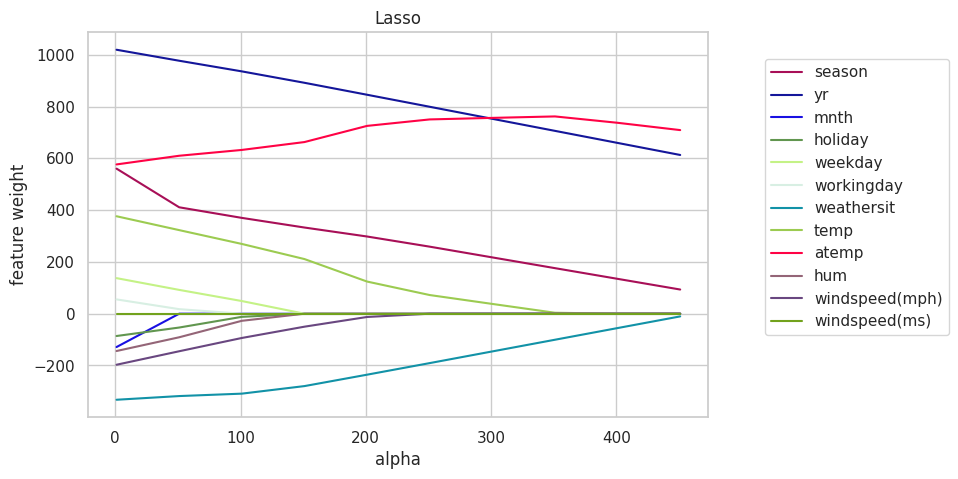

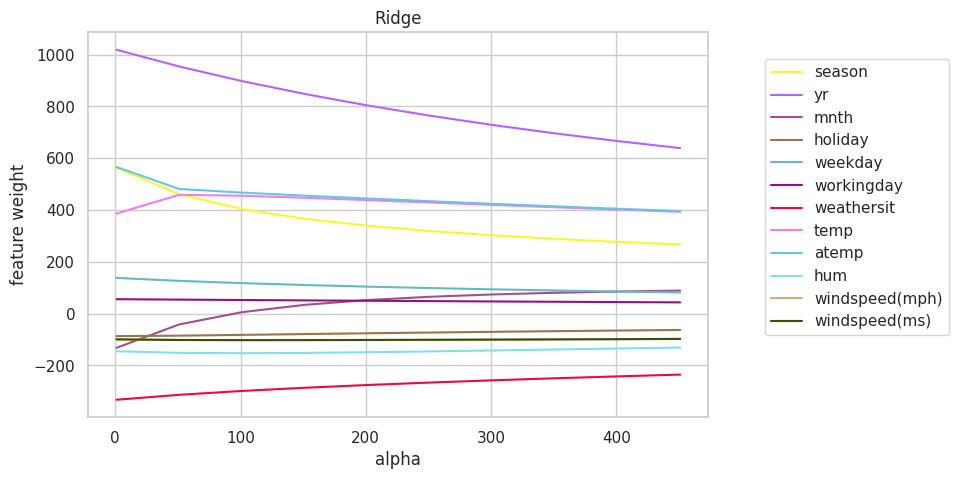

In [20]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:

1. Lasso агресивніше зменшує ваги при збільшенні
α порівняно з Ridge. Це можна побачити на графіку Lasso, де деякі ваги швидко зменшуються до нуля зі збільшенням
α, тоді як на графіку Ridge ваги зменшуються плавніше і не обнуляються так раптово.

2. При дуже великому значенні α, ваги в моделі Lasso можуть бути обнулені. Це відбувається тому, що
L1-регуляризація сприяє створенню розріджених моделей, де багато ваг стають рівними нулю, що ефективно виключає відповідні ознаки з моделі. При великих значеннях α штраф за ненульові ваги стає настільки значним, що оптимізаційний алгоритм мінімізує цей штраф, призначаючи більшості ваг значення нуль.

3. Lasso може виключати одну з ознак windspeed при α>0, як це видно з обнулення однієї з ваг цих ознак на графіку. Ridge, з іншого боку, зменшує ваги ознак плавно і не обнуляє їх повністю, тому не можна стверджувати, що Ridge виключає ознаку за будь-якого значення α.

4.  Lasso підходить для відбору неінформативних ознак, оскільки воно здатне обнуляти ваги менш важливих ознак і таким чином виключати їх з моделі. Ridge, натомість, не обнуляє ваги і тому менш придатний для відбору ознак. ​




### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [21]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

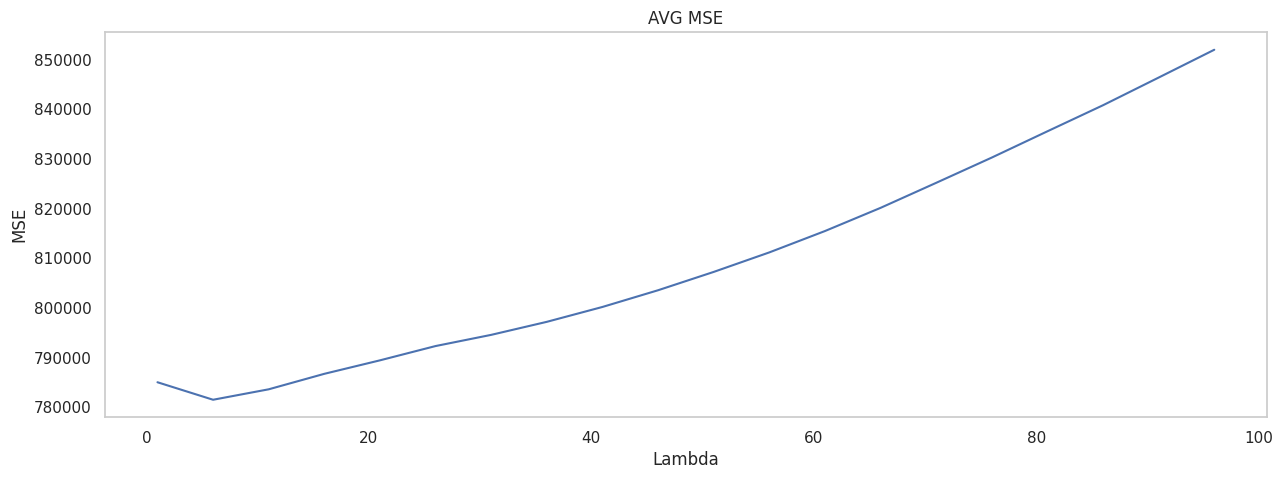

Local minimum alpha: 6, MSE: 781531.0908199243


(6,
 [('season', 532.0189828413535),
  ('yr', 1015.0602226430595),
  ('mnth', -100.03952614356629),
  ('holiday', -83.29395987529904),
  ('weekday', 132.50446549095795),
  ('workingday', 51.557085614073735),
  ('weathersit', -330.5598567399817),
  ('temp', 370.67985503003405),
  ('atemp', 581.396931065498),
  ('hum', -140.00740550068844),
  ('windspeed(mph)', -191.77140847135036),
  ('windspeed(ms)', -2.6854702314758792e-08)])

In [45]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

lasso_cv_regressor = LassoCV(alphas=alphas, cv=3, random_state=42)
lasso_cv_regressor.fit(X, y)

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = [e[0] for e in data]
    y = [e[1] for e in data]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

avg_mse = [(alpha, mse.mean()) for alpha, mse in zip(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_.mean(axis=1))]
create_plot(avg_mse, "AVG MSE", "Lambda", "MSE")

chosen_alpha = lasso_cv_regressor.alpha_
feature_weights = list(zip(df.columns[:-1], lasso_cv_regressor.coef_))

local_min_alpha = min(avg_mse, key=lambda x: x[1])[0]
local_min_mse = min(avg_mse, key=lambda x: x[1])[1]
print(f"Local minimum alpha: {local_min_alpha}, MSE: {local_min_mse}")


chosen_alpha, feature_weights



In [ ]:
"""Після навчання регресора LassoCV з різними значеннями
𝛼, було обрано найкраще значення 𝛼=6
α=6, засноване на усередненому значенні MSE на крос-валідації. Графік показує залежність MSE від параметра регуляризації α, дозволяючи візуально оцінити, як змінюється помилка моделі зі зміною рівня регуляризації.

Навчений вектор коефіцієнтів для вибраного α виглядає наступним чином:
season: 532.02
yr (рік): 1015.06
mnth (місяць): -100.04
holiday: -83.29
weekday: 132.50
workingday: 51.56
weathersit: -330.56
temp (температура в Цельсіях): 370.68
atemp (відчутна температура): 581.40
hum (вологість): -140.01
windspeed(mph): -191.77
windspeed(ms): -2.69e-08
Ці результати показують, що LassoCV здійснило вибір значущих ознак та призначило нульові або дуже малі коефіцієнти неінформативним ознакам, зокрема windspeed(ms), демонструючи здатність Lasso до відбору ознак. Отже, Lasso може бути корисним для побудови інтерпретованих моделей, видаляючи несуттєві ознаки."""

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


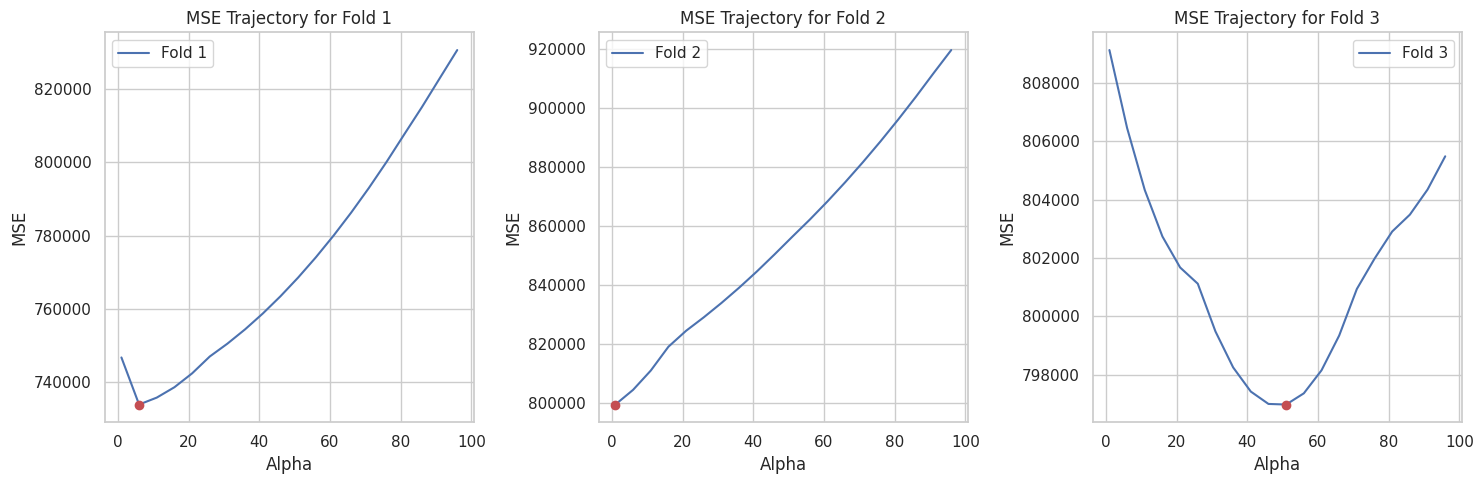

In [46]:
mse_path = lasso_cv_regressor.mse_path_

# значення альфа, яке відповідає мінімальній MSE для кожного згортання
min_mse_alphas = [lasso_cv_regressor.alphas_[np.argmin(mse)] for mse in mse_path.T]
min_mse_alphas

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(lasso_cv_regressor.alphas_, mse_path[:, i], label=f'Fold {i+1}')
    plt.plot(min_mse_alphas[i], np.min(mse_path[:, i]), 'ro')  # Min MSE point
    plt.title(f'MSE Trajectory for Fold {i+1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.legend()

plt.tight_layout()
plt.show()

In [24]:
min_mse_values = [np.min(mse) for mse in mse_path.T]
min_mse_alphas_values = [lasso_cv_regressor.alphas_[np.argmin(mse)] for mse in mse_path.T]

print("Alphas with minimum MSE:")
for alpha, mse in zip(min_mse_alphas_values, min_mse_values):
    print(f"Alpha = {alpha}, MSE = {mse}")

Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052249
Alpha = 1, MSE = 799433.1673691692
Alpha = 51, MSE = 796979.8955193626


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

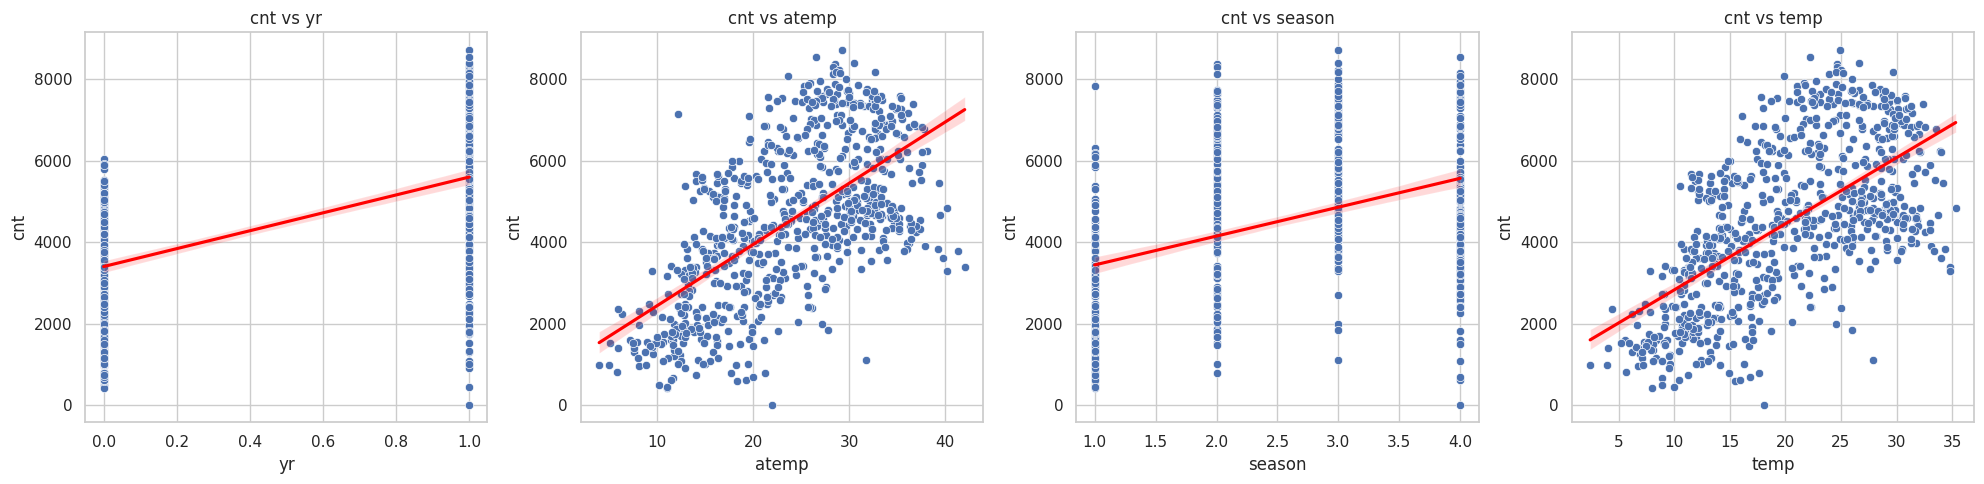

[('yr', 1015.0602226430595),
 ('atemp', 581.396931065498),
 ('season', 532.0189828413535),
 ('temp', 370.67985503003405)]

In [25]:
# Вилучення чотирьох ознак із найбільшими позитивними коефіцієнтами з останньої навченої моделі LassoCV
top_features = sorted(feature_weights, key=lambda x: x[1], reverse=True)[:4]


plt.figure(figsize=(20, 5))

for i, (feature, _) in enumerate(top_features, 1):
    plt.subplot(1, 4, i)
    sns.scatterplot(x=feature, y='cnt', data=df)
    sns.regplot(x=feature, y='cnt', data=df, scatter=False, color='red')
    plt.title(f'cnt vs {feature}')

plt.tight_layout()
plt.show()

top_features


__Відповідь:__

В останній навченій моделі з використанням LassoCV, чотири ознаки з найбільшими позитивними коефіцієнтами:

yr (рік): 1015.06

atemp (відчутна температура): 581.40

season (сезон): 532.02

temp (температура в Цельсіях): 370.68


На основі візуалізацій залежностей між кількістю прокатів велосипедів (cnt) та чотирма ознаками з найбільшими позитивними коефіцієнтами, ми можемо оновити наші спостереження:

yr (рік): Коефіцієнт 1015.06. З року в рік кількість прокатів велосипедів збільшується, що може свідчити про зростаючу популярність сервісу прокату велосипедів або покращення інфраструктури. З графіка видно, що в 2012 році (yr = 1) прокати були популярнішими, ніж у 2011 (yr = 0). Хоча ми маємо тільки 2 роки даних.

atemp (відчутна температура): Коефіцієнт 581.40. Чим вища відчутна температура, тим більше людей вирішують взяти велосипед на прокат. Це відповідає очікуванням, оскільки гарні температурні умови сприяють бажанню проводотитич час на повітрі.

season (сезон): Коефіцієнт 532.02. Сезонний коефіцієнт вказує на зростання кількості прокатів у певні сезони року, що логічно збігається з теплішими періодами року, коли велосипедна активність зазвичай вища.Або тепла осінь.

temp (температура в Цельсіях): Коефіцієнт 370.68. Подібно до atemp, зростаюча температура сприяє збільшенню кількості прокатів.
З візуалізацій залежностей cnt від цих ознак видно, що існує позитивна лінійна залежність між cnt та ознаками yr, atemp, season, та temp. Це підтверджує логічне припущення, що зі збільшенням значення цих ознак кількість людей, які захочуть взяти велосипеди, зростає. Отже, ці ознаки відіграють ключову роль у передбаченні попиту на велосипеди.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__


Три ознаки з найбільшими за модулем негативними коефіцієнтами у навченій моделі LassoCV:

weathersit: -330.56
weathersit (оцінка погоди): Негативний коефіцієнт свідчить про те, що погіршення погодних умов (вище значення ознаки відповідає гіршим погодним умовам) зменшує кількість прокатів велосипедів. Це логічно, оскільки в холодну, дощову або сніжну погоду менше людей вирішує користуватися велосипедами на відкритому повітрі.

windspeed(mph): -191.77
windspeed(mph) (швидкість вітру): Збільшення швидкості вітру зменшує комфорт велосипедистів, що може знизити кількість прокатів. Негативний коефіцієнт вказує на цю тенденцію.

hum (вологість): -140.01
hum (вологість): Висока вологість може зробити погодні умови менш комфортними для катання на велосипеді, особливо в теплу погоду, що відображено негативним коефіцієнтом.

Подивившись на відповідні візуалізації залежностей cnt від цих ознак, можна спостерігати, що із зростанням значень цих ознак кількість прокатів знижується, що вказує на зменшувану лінійну залежність. Зокрема, для "weathersit" можна спостерігати, що з погіршенням погодних умов (зростанням значення ознаки) кількість прокатів зменшується. Аналогічно, зі збільшенням швидкості вітру та вологості спостерігається зниження кількості прокатів.

Таким чином, можна стверджувати, що чим вище значення цих ознак, тим менше людей захочуть взяти велосипеди.

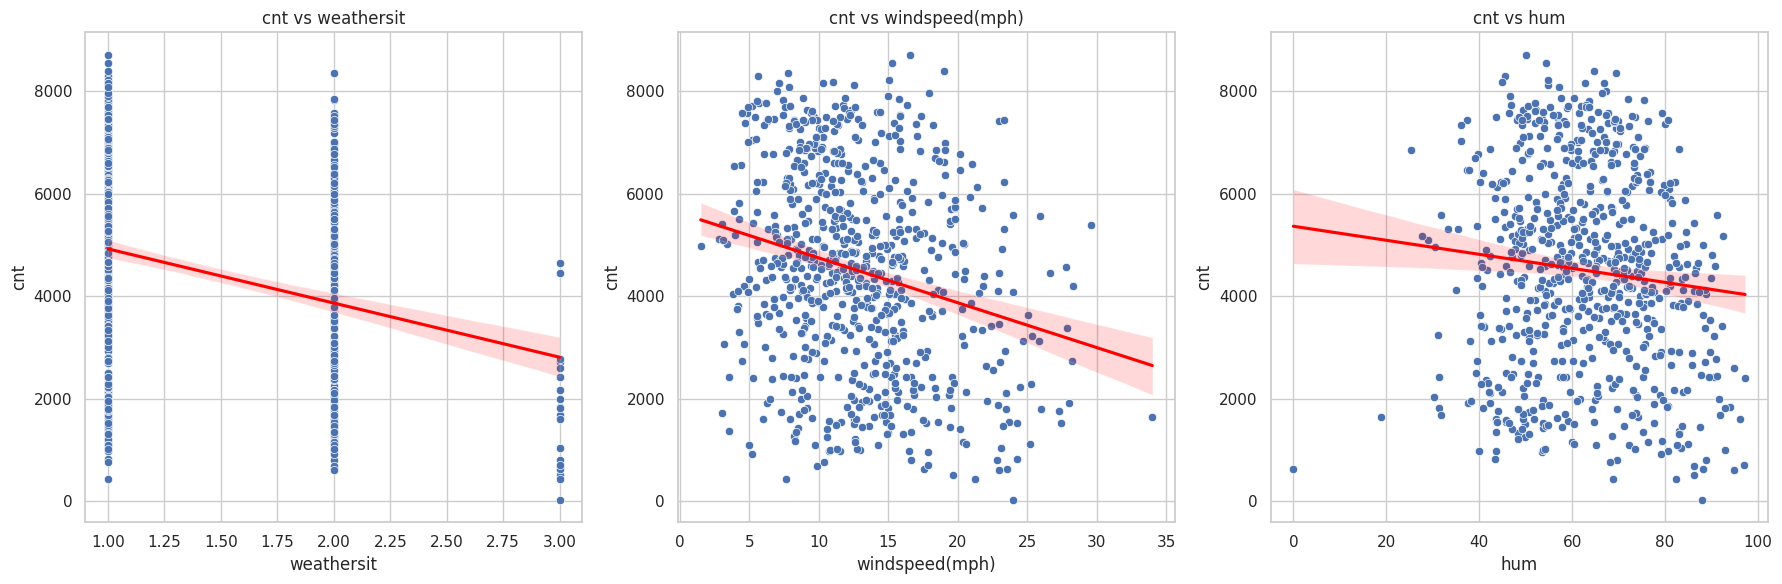

In [26]:

negative_features = ['weathersit', 'windspeed(mph)', 'hum']

plt.figure(figsize=(18, 6))

for i, feature in enumerate(negative_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=feature, y='cnt', data=df)
    sns.regplot(x=feature, y='cnt', data=df, scatter=False, color='red')
    plt.title(f'cnt vs {feature}')

plt.tight_layout()
plt.show()


На графіках представлені залежності кількості прокатів велосипедів (cnt) від трьох ознак із найбільшими за модулем негативними коефіцієнтами: weathersit (оцінка погоди), windspeed(mph) (швидкість вітру в милях за годину), та hum (вологість). Червоні лінії на кожному графіку ілюструють лінійну регресію, вказуючи на зменшувальну тенденцію: зі збільшенням значення кожної з цих ознак кількість прокатів велосипедів зменшується.

Ці графіки демонструють негативний лінійний зв'язок між зазначеними ознаками та цільовою змінною cnt, підтверджуючи нашу попередню інтерпретацію результатів.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Ознака з коефіцієнтом, близьким до нуля (< 1e-3) в останній навченій моделі LassoCV:

windspeed(ms): -2.69e-08
Модель Lasso виключила цю ознаку з моделі, обнуливши її коефіцієнт, через те, що ця ознака є прямим переведенням швидкості вітру з миль за годину в метри за секунду (windspeed(mph) в windspeed(ms)), тому вона не додає нової інформації до моделі. Це приклад мультиколінеарності, коли дві ознаки високо корелюють між собою, що може ускладнити роботу моделі або зробити її інтерпретацію менш зрозумілою.

Подивившись на графіки залежностей cnt від ознак у початковій частині аналізу, ми можемо побачити, що інші ознаки, які мають більш суттєві коефіцієнти, забезпечують більш чіткі та виражені тенденції залежності кількості прокатів велосипедів від різних погодних умов, температур, сезонів тощо.

Не можна стверджувати, що ознака з коефіцієнтом, близьким до нуля, абсолютно не впливає на попит на велосипеди, але в контексті моделі та наявного набору даних її вплив вважається незначним або дублюючим інформацію, що вже представлена іншими ознаками. Таким чином, Lasso вибирає більш інформативні та релевантні ознаки, водночас виключаючи ті, що менш важливі для прогнозування цільової змінної.

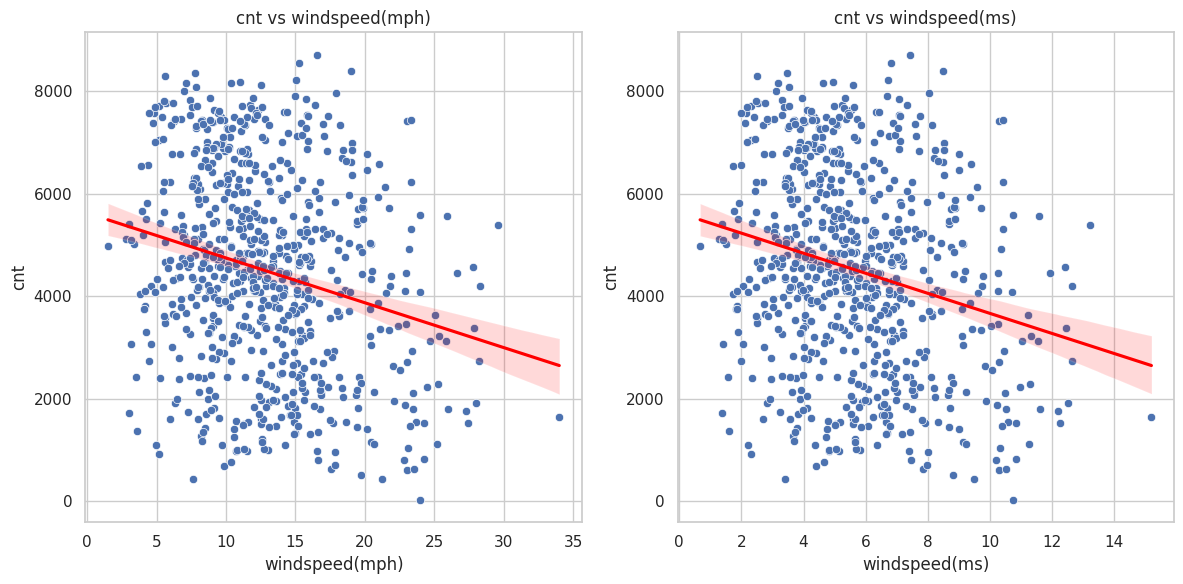

In [27]:
plt.figure(figsize=(12, 6))

# windspeed(mph)
plt.subplot(1, 2, 1)
sns.scatterplot(x='windspeed(mph)', y='cnt', data=df)
sns.regplot(x='windspeed(mph)', y='cnt', data=df, scatter=False, color='red')
plt.title('cnt vs windspeed(mph)')

# windspeed(ms)
plt.subplot(1, 2, 2)
sns.scatterplot(x='windspeed(ms)', y='cnt', data=df)
sns.regplot(x='windspeed(ms)', y='cnt', data=df, scatter=False, color='red')
plt.title('cnt vs windspeed(ms)')

plt.tight_layout()
plt.show()


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.

**Не перевіряти**

**Додатки і тестування графіків та візуалізація різних даних. **

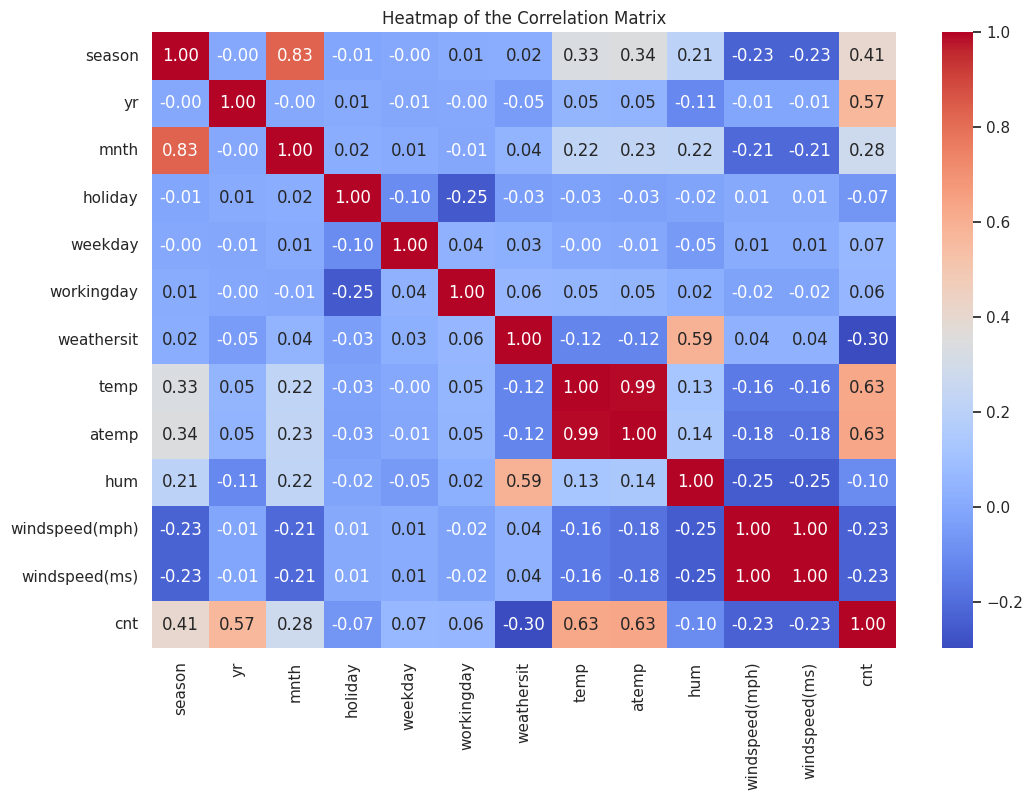

In [28]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of the Correlation Matrix')
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

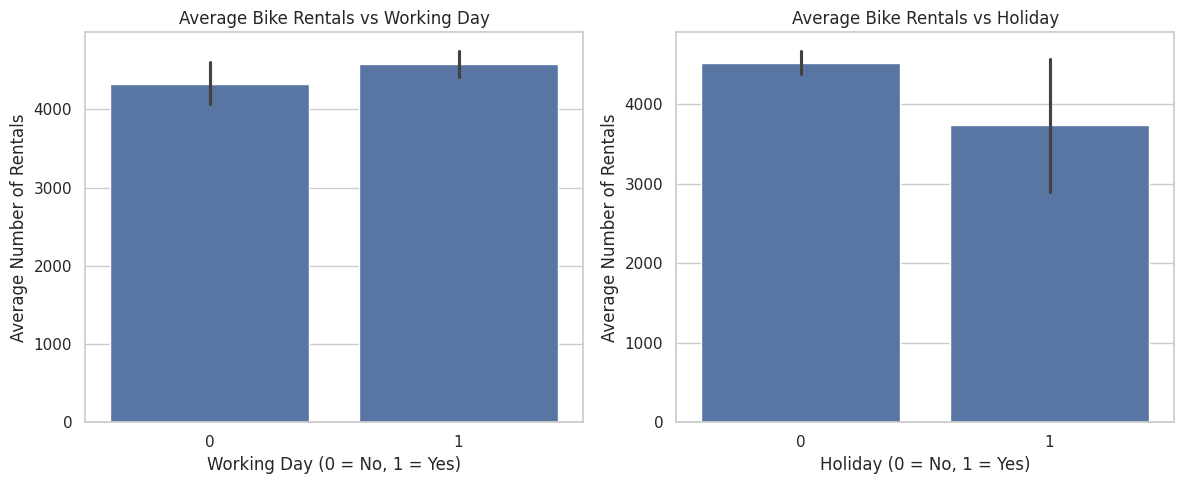

In [29]:
plt.figure(figsize=(12, 5))

# workingday
plt.subplot(1, 2, 1)
sns.barplot(x='workingday', y='cnt', data=df)
plt.title('Average Bike Rentals vs Working Day')
plt.xlabel('Working Day (0 = No, 1 = Yes)')
plt.ylabel('Average Number of Rentals')

# holiday
plt.subplot(1, 2, 2)
sns.barplot(x='holiday', y='cnt', data=df)
plt.title('Average Bike Rentals vs Holiday')
plt.xlabel('Holiday (0 = No, 1 = Yes)')
plt.ylabel('Average Number of Rentals')

plt.tight_layout()
plt


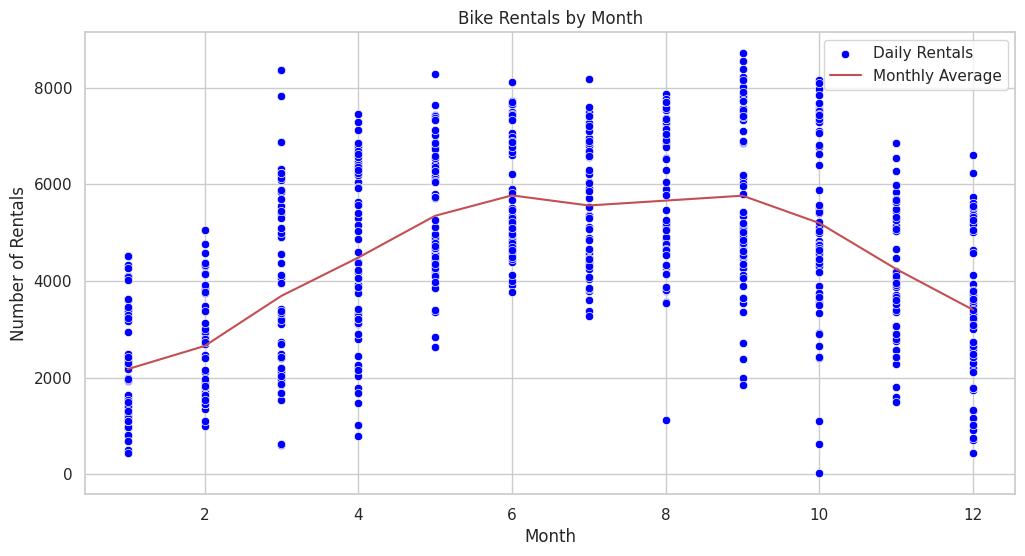

In [51]:
# середня кількість орендованих місць за кожен місяць за всі роки
monthly_avg = df.groupby('mnth')['cnt'].mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='mnth', y='cnt', data=df, color='blue', label='Daily Rentals')
plt.plot(monthly_avg.index, monthly_avg.values, 'r-', label='Monthly Average')
plt.title('Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-49-5af82c3d27cd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='yr', y='cnt', data=df, palette='coolwarm', errorbar=None)


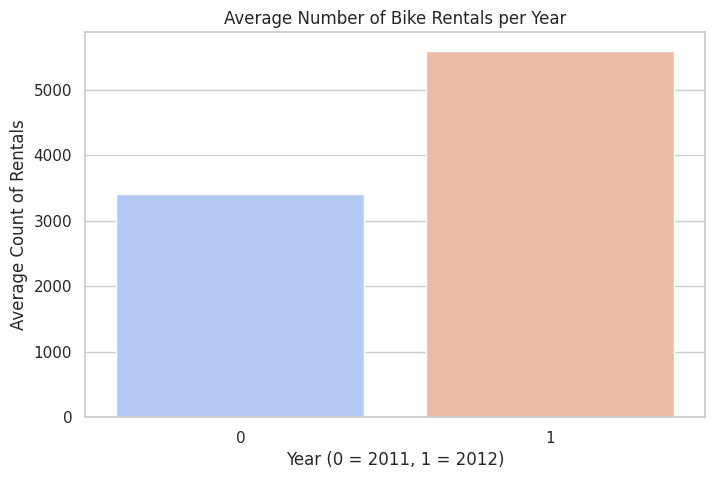

In [49]:

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(x='yr', y='cnt', data=df, palette='coolwarm', errorbar=None)
plt.title('Average Number of Bike Rentals per Year')
plt.xlabel('Year (0 = 2011, 1 = 2012)')
plt.ylabel('Average Count of Rentals')
plt.show()


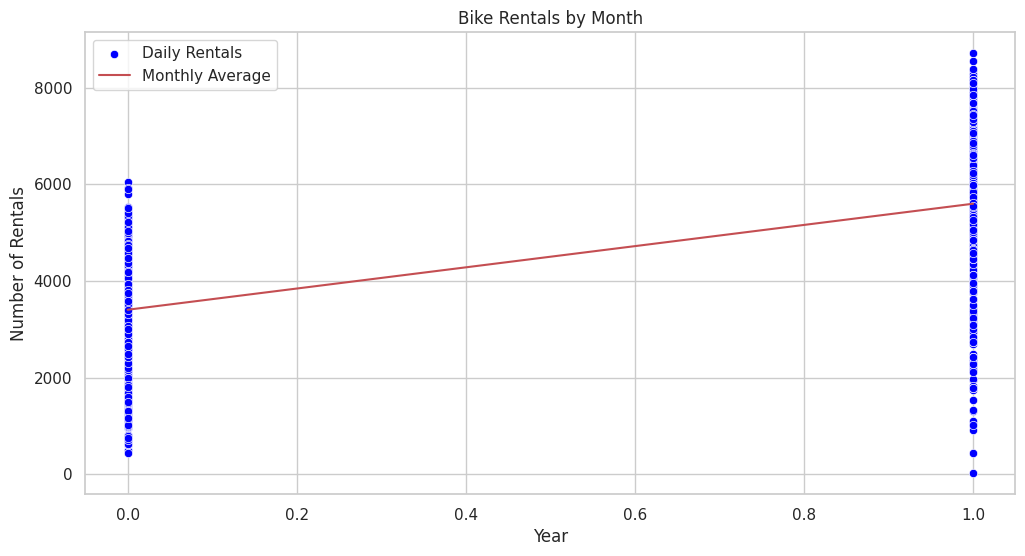

In [53]:
# середня кількість орендованих місць за кожен місяць за всі роки
monthly_avg = df.groupby('yr')['cnt'].mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='yr', y='cnt', data=df, color='blue', label='Daily Rentals')
plt.plot(monthly_avg.index, monthly_avg.values, 'r-', label='Monthly Average')
plt.title('Bike Rentals by Month')
plt.xlabel('Year')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

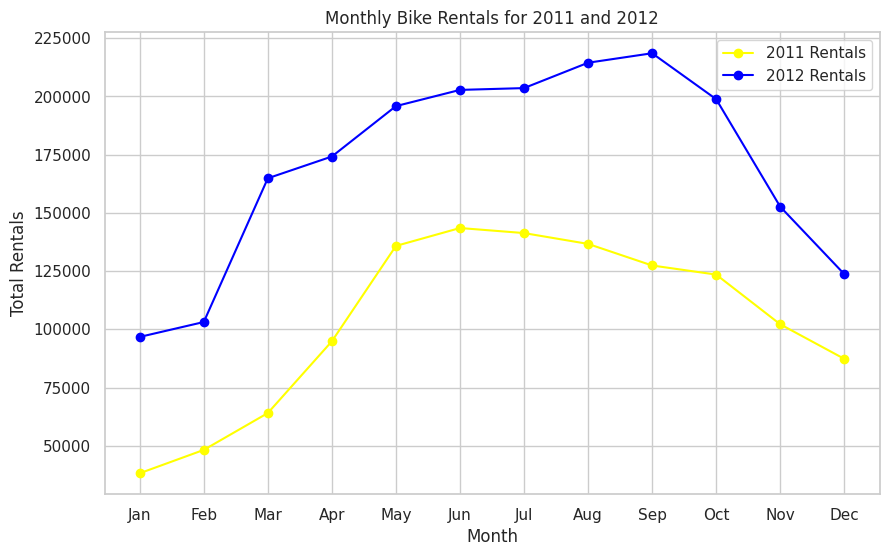

In [60]:
# Filtering and grouping data for 2011
total_rentals_2011 = df[df['yr'] == 0].groupby('mnth')['cnt'].sum()

# Filtering and grouping data for 2012
total_rentals_2012 = df[df['yr'] == 1].groupby('mnth')['cnt'].sum()

plt.figure(figsize=(10, 6))
plt.plot(total_rentals_2011.index, total_rentals_2011.values, label='2011 Rentals', color='yellow', marker='o')
plt.plot(total_rentals_2012.index, total_rentals_2012.values, label='2012 Rentals', color='blue', marker='o')
plt.title('Monthly Bike Rentals for 2011 and 2012')
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()


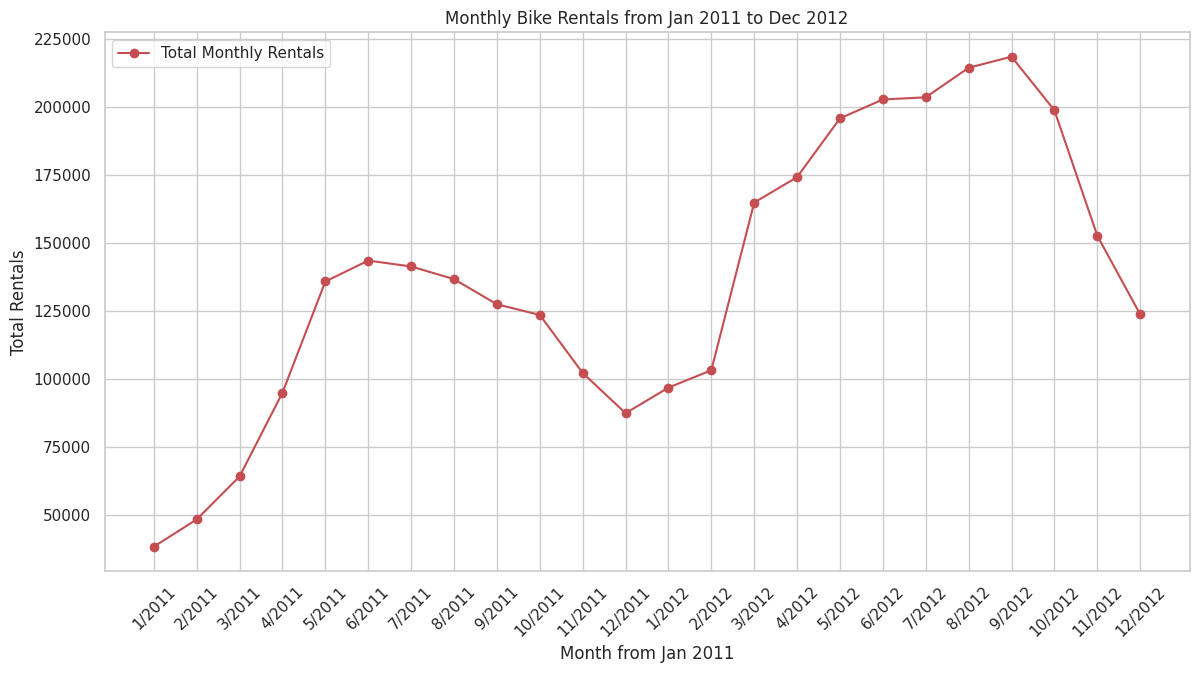

In [70]:
# Assuming the dataframe 'bikes_data' contains 'yr', 'mnth', and 'cnt'
# Create a unique identifier for each month from January 2011 to December 2012
df['unique_month'] = ((df['yr']+1) * 12 + df['mnth']) - 12  # Normalize to start from 1

# Group by the unique month identifier to sum rentals per month
total_rentals_by_unique_month = df.groupby('unique_month')['cnt'].sum()

# Plot the data with all months labeled
plt.figure(figsize=(14, 7))
plt.plot(total_rentals_by_unique_month.index, total_rentals_by_unique_month.values, 'r-o', label='Total Monthly Rentals')
plt.title('Monthly Bike Rentals from Jan 2011 to Dec 2012')
plt.xlabel('Month from Jan 2011')
plt.ylabel('Total Rentals')

# Generate month labels
months_labels = [f'{month}/{year}' for year in [2011, 2012] for month in range(1, 13)]
plt.xticks(ticks=range(1, 25), labels=months_labels, rotation=45)  # Rotate for better readability

plt.legend()
plt.grid(True)
plt.show()


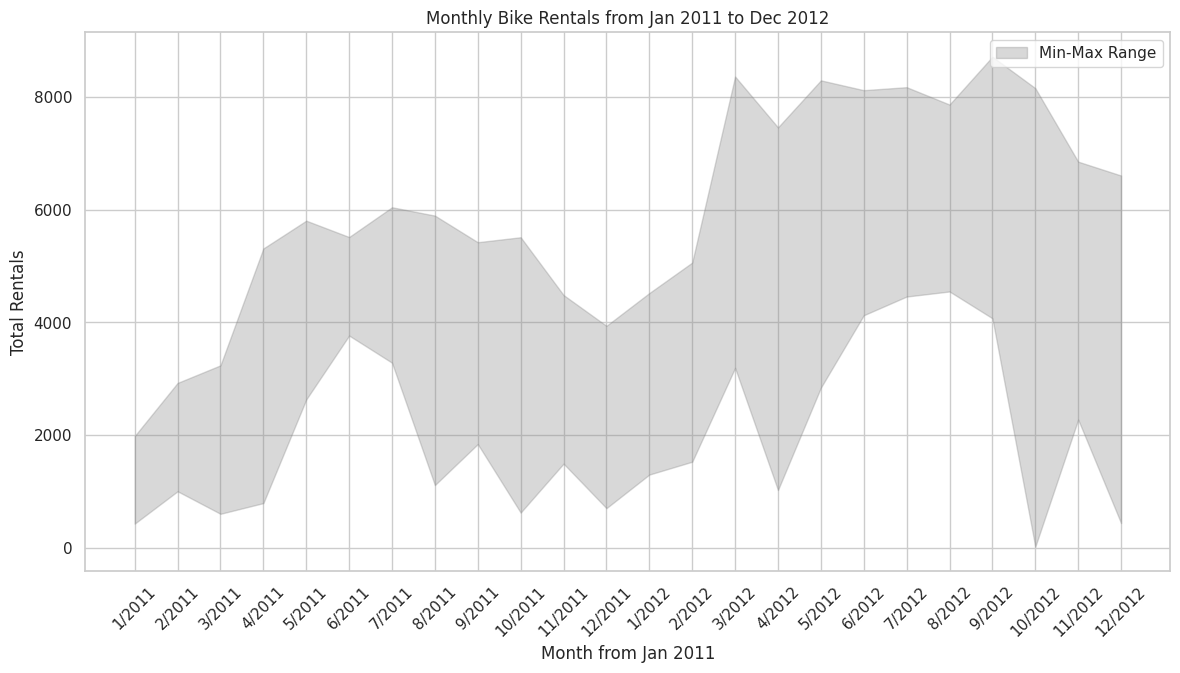

In [72]:

df['unique_month'] = ((df['yr'] + 1) * 12 + df['mnth']) - 12  # Normalize to start from 1


monthly_stats = df.groupby('unique_month')['cnt'].agg(['sum', 'min', 'max'])

# Plot the data with all months labeled
plt.figure(figsize=(14, 7))
#plt.plot(monthly_stats['sum'].index, monthly_stats['sum'].values, 'r-o', label='Total Monthly Rentals')
plt.fill_between(monthly_stats.index, monthly_stats['min'], monthly_stats['max'], color='gray', alpha=0.3, label='Min-Max Range')
plt.title('Monthly Bike Rentals from Jan 2011 to Dec 2012')
plt.xlabel('Month from Jan 2011')
plt.ylabel('Total Rentals')

# Generate month labels
months_labels = [f'{month}/{year}' for year in [2011, 2012] for month in range(1, 13)]
plt.xticks(ticks=range(1, 25), labels=months_labels, rotation=45)  # Rotate for better readability

plt.legend()
plt.grid(True)
plt.show()
